
### Install Packages

In [ ]:
#import sys
#!{sys.executable} -m pip install --user -r requirements.txt

#import sys
#alphalens
#nltk==3.3.0
#numpy==1.13.3
#ratelimit==2.2.0
#requests==2.18.4
#scikit-learn==0.19.1
#six==1.11.0
#tqdm==4.19.5


### Load Packages

In [17]:
import os
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests

from tqdm import tqdm

### Download NLP Corpora
You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/gege/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gege/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Get 10ks
We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for a few companies. To lookup documents for these companies, we'll use their CIK. If you would like to run this against other stocks, we've provided the dict `additional_cik` for more stocks. However, the more stocks you try, the long it will take to run.

In [19]:
cik_lookup = {
    'ROKU': '0001428439',
    'MRNA': '0001682852',
    'AMD':  '0000002488',
    'GILD': '0000882095',
    'INO':  '0001055726',
    'MSFT': '0000789019'
}

additional_cik = {
    'GILD': ' 0000882095',
    'BNTX': ' 0001776985' 
     
     }

In [20]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840',
    'ROKU': '0001428439',
    'MSFT': '0000789019',
    'AMD': '0000002488',
    'INO': '0001055726'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

In [21]:
cik_lookup


{'AMZN': '0001018724',
 'BMY': '0000014272',
 'CNP': '0001130310',
 'CVX': '0000093410',
 'FL': '0000850209',
 'FRT': '0000034903',
 'HON': '0000773840',
 'ROKU': '0001428439',
 'MSFT': '0000789019',
 'AMD': '0000002488',
 'INO': '0001055726'}

### Get list of 10-ks
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the `SecAPI` class. This will cache data from the SEC and prevent you from going over the limit.

In [22]:
sec_api = project_helper.SecAPI()

With the class constructed, let's pull a list of filled 10-ks from the SEC for each company.

In [23]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    #newest_pricing_data = pd.to_datetime('2018-01-01')
    newest_pricing_data = pd.to_datetime('2021-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example. 

In [24]:
example_ticker = 'MSFT'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
    #sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/789019/000156459020034944/0001564590-20-034944-index.htm',
  '10-K',
  '2020-07-31'),
 ('https://www.sec.gov/Archives/edgar/data/789019/000156459019027952/0001564590-19-027952-index.htm',
  '10-K',
  '2019-08-01'),
 ('https://www.sec.gov/Archives/edgar/data/789019/000156459018019062/0001564590-18-019062-index.htm',
  '10-K',
  '2018-08-03'),
 ('https://www.sec.gov/Archives/edgar/data/789019/000156459017014900/0001564590-17-014900-index.htm',
  '10-K',
  '2017-08-02'),
 ('https://www.sec.gov/Archives/edgar/data/789019/000119312516662209/0001193125-16-662209-index.htm',
  '10-K',
  '2016-07-28')]


In [ ]:
example_ticker = 'MSFT'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
    #sec_data[ticker] = get_sec_data(cik, '10-Q')

pprint.pprint(sec_data[example_ticker][:5])

### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [25]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
        #if (file_type == '10-Q'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001564590-20-034944.txt : 20200731
<SEC-HEADER>0001564590-20-034944.hdr.sgml : 20200731
<ACCEPTANCE-DATETIME>20200730204446
ACCESSION NUMBER:		0001564590-20-034944
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		139
CONFORMED PERIOD OF REPORT:	20200630
FILED AS OF DATE:		20200731
DATE AS OF CHANGE:		20200730

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			MICROSOFT CORP
		CENTRAL INDEX KEY:			0000789019
		STANDARD INDUSTRIAL CLASSIFICATION:	SERVICES-PREPACKAGED SOFTWARE [7372]
		IRS NUMBER:				911144442
		STATE OF INCORPORATION:			WA
		FISCAL YEAR END:			0630

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-37845
		FILM NUMBER:		201063171

	BUSINESS ADDRESS:	
		STREET 1:		ONE MICROSOFT WAY
		CITY:			REDMOND
		STATE:			WA
		ZIP:			98052-6399
		BUSINESS PHONE:		425-882-8080

	MAIL ADDRESS:	
		STREET 1:		ONE MICROSOFT WAY
		CITY:			REDMOND
		STATE:			WA
		ZIP:			98052-6399
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<SE

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [26]:
import re
import project_tests


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    #print(text)
    
    # TODO: Implement
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
  
    
    # Create 3 lists with the span idices for each regex
    doc_start_is = [a.end() for a in doc_start_pattern.finditer(text)]
    doc_end_is = [a.start() for a in doc_end_pattern.finditer(text)]
    
   
  
    document_list = []

     # Create a loop to go through each section type and save only the 10-K section in the dictionary
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
            document_list.append(text[doc_start_i:doc_end_i]) 
    return document_list
             


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [27]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from INO Fillings: 100%|██████████| 19/19 [00:20<00:00,  1.09s/filling]


Document 0 Filed on 2020-07-31:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>msft-10k_20200630.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml  version="1.0" encoding="utf-8"?>
<!-- DFIN ActiveDisclosure(SM) Inline XBRL Document - http://www.dfinsol...

Document 1 Filed on 2020-07-31:

<TYPE>EX-10.25
<SEQUENCE>2
<FILENAME>msft-ex1025_365.htm
<DESCRIPTION>EX-10.25
<TEXT>
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
<he...

Document 2 Filed on 2020-07-31:

<TYPE>EX-10.26
<SEQUENCE>3
<FILENAME>msft-ex1026_364.htm
<DESCRIPTION>EX-10.26
<TEXT>
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
<he...


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [28]:
import re

def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    
    
    type_pattern = re.compile(r'<TYPE>[^\n]+') 
    doc_types = [a[len('<TYPE>'):] for a in type_pattern.findall(doc)]
  
    return doc_types[0].lower()


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [29]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
            #if get_document_type(document) == '10-q':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000789019'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>msft-10k_202...
    file_date: '2020-07-31'},
  {
    cik: '0000789019'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>msft-10k_201...
    file_date: '2019-08-01'},
  {
    cik: '0000789019'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>msft-10k_201...
    file_date: '2018-08-03'},
  {
    cik: '0000789019'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>msft-10k_201...
    file_date: '2017-08-02'},
  {
    cik: '0000789019'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d187868d10k....
    file_date: '2016-07-28'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [30]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the clean_text function, we'll clean up all the documents.

In [31]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
    #for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-qs'.format(ticker), unit='10-Q'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning INO 10-Ks: 100%|██████████| 19/19 [00:35<00:00,  1.84s/10-K]

[
  {
    file_clean: '\n10-k\n1\nmsft-10k_20200630.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\nmsft-10k_20190630.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\nmsft-10k_20180630.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\nmsft-10k_20170630.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\nd187868d10k.htm\n10-k\n\n\n10-k\n\n\nt...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [32]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    lemmed = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    
    
    return lemmed


project_tests.test_lemmatize_words(lemmatize_words)

Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the data.

In [33]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
    #for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Qs'.format(ticker), unit='10-Q'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize INO 10-Ks: 100%|██████████| 19/19 [00:36<00:00,  1.92s/10-K]


[
  {
    file_lemma: '['TYPE', '10', 'K', 'SEQUENCE', '1', 'FILENAME', ...},
  {
    file_lemma: '['TYPE', '10', 'K', 'SEQUENCE', '1', 'FILENAME', ...},
  {
    file_lemma: '['TYPE', '10', 'K', 'SEQUENCE', '1', 'FILENAME', ...},
  {
    file_lemma: '['TYPE', '10', 'K', 'SEQUENCE', '1', 'FILENAME', ...},
  {
    file_lemma: '['TYPE', '10', 'K', 'SEQUENCE', '1', 'FILENAME', ...},
]


### Remove Stopwords

In [34]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
    #for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Qs'.format(ticker), unit='10-Q'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for INO 10-Ks: 100%|██████████| 19/19 [00:19<00:00,  1.04s/10-K]

Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [35]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

#sentiment_df = pd.read_csv(os.path.join('..', '..', 'data', 'project_5_loughran_mcdonald', 'loughran_mcdonald_master_dic_2016.csv'))

sentiment_df = pd.read_csv("loughran_mcdonald_master_dic_2016.csv")

sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()
sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


In [36]:
sentiment_df

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication
...,...,...,...,...,...,...,...
84770,True,False,False,False,False,False,wrongdoing
84771,True,False,False,False,False,False,wrongdoings
84775,True,False,False,False,False,False,wrongful
84776,True,False,False,False,False,False,wrongfully


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [37]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    
    count_vector = CountVectorizer(vocabulary=sentiment_words)
    bag = count_vector.fit_transform(docs)    
   
    return bag.toarray()


project_tests.test_get_bag_of_words(get_bag_of_words)

Tests Passed


Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [38]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[3 0 0 ... 0 0 0]\n [3 0 0 ... 0 0 0]\n [6 0 0 ....
    uncertainty: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 1 0 ... 0 0 2]\n [0 1 0 ....
    interesting: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....},
]


### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, you just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.

In [39]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    
    bag_of_words_matrix_bool = bag_of_words_matrix.astype(bool)
    
    jaccard_similarity = []
    
    jaccard_similarity = [jaccard_similarity_score(u,v) 
            for u, v in zip(bag_of_words_matrix_bool, bag_of_words_matrix_bool[1:])]
    
    return jaccard_similarity


project_tests.test_get_jaccard_similarity(get_jaccard_similarity)

Tests Passed


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Using the `get_jaccard_similarity` function, let's plot the similarities over time.

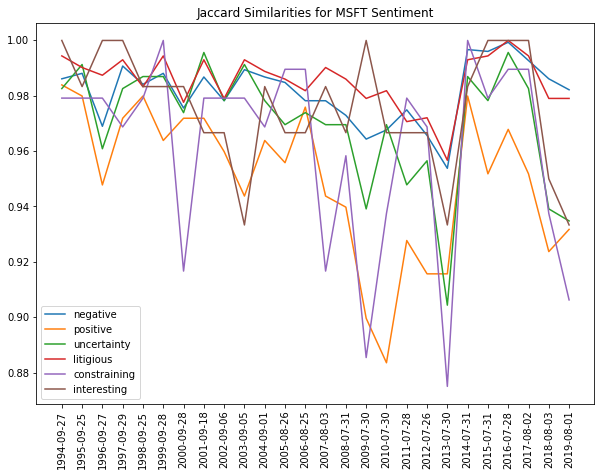

In [40]:
# Get dates for the universe

example_ticker = 'MSFT'
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
  
    vectorizer = TfidfVectorizer(vocabulary = sentiment_words)
    array_of_tfidf = vectorizer.fit_transform(docs)
    
    return array_of_tfidf.toarray()


project_tests.test_get_tfidf(get_tfidf)

Tests Passed


Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [42]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    positive: '[[0.02657516 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.        ...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.         0.         0.         ... 0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement 
    
    cosine_similarity_values = cosine_similarity(tfidf_matrix, tfidf_matrix[1:])
    
    return cosine_similarity_values[0].tolist()


project_tests.test_get_cosine_similarity(get_cosine_similarity)

Tests Passed


Let's plot the cosine similarities over time.

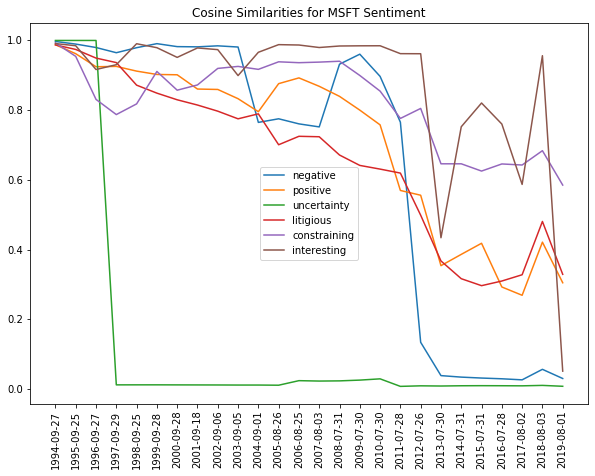

In [44]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## Evaluate Alpha Factors
Just like we did in project 4, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.
### Price Data
Let's get yearly pricing to run the factor against, since 10-Ks are produced annually.

In [30]:
## From SQL to DataFrame Pandas
import pandas as pd
import pyodbc
import pandas as pd
from  matplotlib import pyplot as plt, rc
from sqlalchemy.sql import select


server = 'Desktop-TQ6JEVI' 
database = 'Stocks' 
username = 'access_stock' 
password = '@cc355stock' 
engine = pyodbc.connect('DRIVER={ODBC Driver 19 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#query = """select trade_date,"close" from equity_history where ticker='AMD' """

query = """SELECT  Symbol AS ticker, PriceDate AS date, adj_close FROM dbo.FctEquity WHERE Symbol IN  ('ROKU', 'MSFT', 'AMD', 'INO', 'AIM')
 """

#print('This is the SQL statement we send: \n {}'.format(query))
#df = pd.read_sql_query(query, engine, index_col='date', parse_dates=['date'])

df = pd.read_sql_query(query, engine,  parse_dates=['date'])
df.head(3)

Error: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 19 for SQL Server' : file not found (0) (SQLDriverConnect)")

In [64]:
#pricing = pd.read_csv('../../data/project_5_yr/yr-quotemedia.csv', parse_dates=['date'])

pricing  = pd.read_csv('/Users/gege/Downloads/Export_Stock_Data.csv')

pricing = pricing.pivot(index='Date', columns='Symbol', values='Close')


pricing

Symbol,A,AAL,AAPL,ABBV,ABT,ACN,ACWI,ADBE,ADI,ADP,...,XOP,XRT,YUM,Z,ZBH,ZEN,ZM,ZNGA,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,64.84413676,31.96822765,154.50742317,81.17087582,67.54070558,137.16136831,62.06859279,224.57000000,83.25327270,125.83023818,...,105.75021577,40.53763197,89.07640201,30.35000000,101.07981392,57.59000000,nan,3.98000000,39.81000000,83.57748969
2019-01-03,62.45529811,29.58635848,139.11734106,78.49641236,64.35317300,132.47842808,61.01379444,215.70000000,78.22435644,122.03038543,...,105.01395556,39.97203595,86.83585384,29.92000000,99.25152241,55.54000000,nan,3.92000000,39.32000000,80.68868441
2019-01-04,64.61709838,31.53516053,145.05617122,81.02532679,66.18989147,137.62966234,62.95888131,226.19000000,80.12352328,126.89381019,...,110.94278774,41.20074454,89.09588504,30.80000000,102.64127370,58.22000000,nan,4.02000000,41.77000000,83.85449842
2019-01-07,65.98919992,32.43082208,144.73330237,82.20791268,67.18113635,138.10771249,63.34596327,229.26000000,80.62738387,126.20732280,...,114.74034038,42.47821142,88.99846990,30.85000000,102.68080433,61.28000000,nan,4.07000000,43.56000000,84.35905002
2019-01-08,66.95658086,31.90917305,147.49236350,82.58997888,66.37453512,141.60040541,63.81046163,232.68000000,82.59437809,126.95182321,...,115.78660488,42.84877433,88.82312265,31.76000000,100.37814529,63.25000000,nan,4.14000000,43.98000000,85.61548246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-06,97.45000000,13.04000000,454.77095807,92.57000000,101.75000000,230.89000000,79.72000000,464.11000000,116.74000000,136.52000000,...,53.20000000,49.67000000,90.99000000,71.42000000,132.99000000,90.87000000,268.25000000,9.95000000,132.28000000,161.33000000
2020-08-07,97.78000000,13.03000000,444.45000000,92.92000000,101.23000000,231.56000000,79.36000000,449.57000000,116.32000000,137.99000000,...,54.13000000,50.72000000,90.82000000,79.76000000,139.38000000,88.38000000,258.73000000,9.73000000,125.85000000,158.88000000
2020-08-10,97.14000000,14.00000000,450.91000000,92.38000000,100.04000000,230.34000000,79.56000000,443.29000000,116.76000000,138.17000000,...,56.13000000,50.99000000,91.34000000,79.34000000,138.38000000,87.26000000,250.00000000,9.47000000,122.39000000,158.09000000


In [65]:
df=pd.read_csv('/Users/gege/Downloads/Export_Stock_Data.csv')
df1 = df[['Symbol', 'Close']]
df1

,Symbol,Close
0,A,97.63000000
1,A,96.30000000
2,A,97.14000000
3,A,97.78000000
4,A,97.45000000
...,...,...
200704,ZTS,85.61548246
200705,ZTS,84.35905002
200706,ZTS,83.85449842
200707,ZTS,80.68868441


In [66]:
pricing = df.pivot(index = 'Date', columns='Symbol', values='Close')
pricing.head(3)

Symbol,A,AAL,AAPL,ABBV,ABT,ACN,ACWI,ADBE,ADI,ADP,...,XOP,XRT,YUM,Z,ZBH,ZEN,ZM,ZNGA,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,64.84413676,31.96822765,154.50742317,81.17087582,67.54070558,137.16136831,62.06859279,224.57000000,83.25327270,125.83023818,...,105.75021577,40.53763197,89.07640201,30.35000000,101.07981392,57.59000000,nan,3.98000000,39.81000000,83.57748969
2019-01-03,62.45529811,29.58635848,139.11734106,78.49641236,64.35317300,132.47842808,61.01379444,215.70000000,78.22435644,122.03038543,...,105.01395556,39.97203595,86.83585384,29.92000000,99.25152241,55.54000000,nan,3.92000000,39.32000000,80.68868441
2019-01-04,64.61709838,31.53516053,145.05617122,81.02532679,66.18989147,137.62966234,62.95888131,226.19000000,80.12352328,126.89381019,...,110.94278774,41.20074454,89.09588504,30.80000000,102.64127370,58.22000000,nan,4.02000000,41.77000000,83.85449842


### Dict to DataFrame
The alphalens library uses dataframes, so we we'll need to turn our dictionary into a dataframe. 

In [47]:
cosine_similarities_df_dict = {'Date': [], 'Symbol': [], 'sentiment': [], 'value': []}
for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values[1:]): ##// remove sentiment value for 2018
            cosine_similarities_df_dict['Symbol'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['Date'].append(file_dates[ticker][2:][sentiment_values]) ##// exclude 2018 
cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['Date'] = pd.DatetimeIndex(cosine_similarities_df['Date']).year
cosine_similarities_df['Date'] = pd.to_datetime(cosine_similarities_df['Date'], format='%Y')
cosine_similarities_df.head()

,Date,Symbol,sentiment,value
0,2018-01-01,AMZN,negative,0.98130584
1,2017-01-01,AMZN,negative,0.97350785
2,2016-01-01,AMZN,negative,0.97253167
3,2015-01-01,AMZN,negative,0.96002015
4,2014-01-01,AMZN,negative,0.95505450


In [48]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}
for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])
cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')
cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2019-01-01,AMZN,negative,0.99313496
1,2018-01-01,AMZN,negative,0.98130584
2,2017-01-01,AMZN,negative,0.97350785
3,2016-01-01,AMZN,negative,0.97253167
4,2015-01-01,AMZN,negative,0.96002015


In [49]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2019-01-01,AMZN,negative,0.99313496
1,2018-01-01,AMZN,negative,0.98130584
2,2017-01-01,AMZN,negative,0.97350785
3,2016-01-01,AMZN,negative,0.97253167
4,2015-01-01,AMZN,negative,0.96002015


### Alphalens Format
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [52]:
#pip install --user -r alphalens == 0.3.6



import alphalens as al


factor_data = {}
skipped_sentiments = []

for sentiment in sentiments:
    cs_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')

    try:
        data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing, quantiles=5, bins=None, periods=[1])
        factor_data[sentiment] = data
    except:
        skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()


Skipped the following sentiments:
negative
positive
uncertainty
litigious
constraining
interesting


KeyError: 'negative'

In [53]:
pricing.head()


Symbol,A,AAL,AAPL,ABBV,ABT,ACN,ACWI,ADBE,ADI,ADP,...,XOP,XRT,YUM,Z,ZBH,ZEN,ZM,ZNGA,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-01-03,64.84413676,31.96822765,154.50742317,81.17087582,67.54070558,137.16136831,62.06859279,224.57000000,83.25327270,125.83023818,...,105.75021577,40.53763197,89.07640201,30.35000000,101.07981392,57.59000000,nan,3.98000000,39.81000000,83.57748969
2019-01-04,62.45529811,29.58635848,139.11734106,78.49641236,64.35317300,132.47842808,61.01379444,215.70000000,78.22435644,122.03038543,...,105.01395556,39.97203595,86.83585384,29.92000000,99.25152241,55.54000000,nan,3.92000000,39.32000000,80.68868441
2019-01-07,64.61709838,31.53516053,145.05617122,81.02532679,66.18989147,137.62966234,62.95888131,226.19000000,80.12352328,126.89381019,...,110.94278774,41.20074454,89.09588504,30.80000000,102.64127370,58.22000000,nan,4.02000000,41.77000000,83.85449842
2019-01-08,65.98919992,32.43082208,144.73330237,82.20791268,67.18113635,138.10771249,63.34596327,229.26000000,80.62738387,126.20732280,...,114.74034038,42.47821142,88.99846990,30.85000000,102.68080433,61.28000000,nan,4.07000000,43.56000000,84.35905002


In [54]:
cs_df

ticker,AMD,AMZN,BMY,CNP,CVX,FL,FRT,HON,INO,MSFT,ROKU
date,,,,,,,,,,,
1994-01-01,0.66803828,nan,0.80099575,nan,0.94524352,nan,0.89342002,nan,nan,0.05130301,nan
1995-01-01,0.61686466,nan,0.85610992,nan,0.94900378,nan,nan,0.18493807,nan,0.95626633,nan
1996-01-01,nan,nan,0.84707379,nan,0.95297105,nan,0.87992370,0.25583391,nan,0.58701992,nan
1997-01-01,0.75137553,nan,0.87009536,nan,nan,nan,0.84566994,nan,nan,0.76019642,nan
1998-01-01,nan,nan,0.86867955,nan,nan,nan,nan,0.49501337,nan,0.82054501,nan
1999-01-01,0.75626330,0.92488024,0.88644462,nan,0.93842438,nan,0.89577033,nan,nan,0.75239188,nan
2000-01-01,nan,0.98461581,0.89153061,nan,0.92191324,nan,nan,nan,nan,0.43403579,nan
2001-01-01,nan,nan,0.87794945,nan,0.92326558,nan,nan,0.67967907,nan,0.96188000,nan
2002-01-01,0.80261101,nan,nan,nan,nan,0.33308989,nan,0.73190497,0.61594825,0.96213286,nan


### Alphalens Format with Unix Time
Alphalen's `factor_rank_autocorrelation` and `mean_return_by_quantile` functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [68]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

In [69]:
cosine_similarities_df

,date,ticker,sentiment,value
0,2019-01-01,AMZN,negative,0.99313496
1,2018-01-01,AMZN,negative,0.98130584
2,2017-01-01,AMZN,negative,0.97350785
3,2016-01-01,AMZN,negative,0.97253167
4,2015-01-01,AMZN,negative,0.96002015
...,...,...,...,...
1273,2006-01-01,INO,interesting,0.72259276
1274,2005-01-01,INO,interesting,0.79159965
1275,2004-01-01,INO,interesting,0.79505051
1276,2003-01-01,INO,interesting,0.78753558


In [70]:
factor_data.items()

dict_items([])

### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [40]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

TypeError: no numeric data to plot

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [58]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

TypeError: no numeric data to plot

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

In [59]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

TypeError: no numeric data to plot

### Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [60]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

NameError: name 'ls_factor_returns' is not defined